## **第6回レポート課題その1**

### 1.CIFAR10の学習

#### 1.1 CIFAR10の読み込みおよび正規化

In [23]:
import torch
import torchvision
import torchvision.transforms as transforms

In [24]:
# [0,1] -> [-1,1]
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])   # (X - 0.5) / 0.5
 
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)
 
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)
 
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


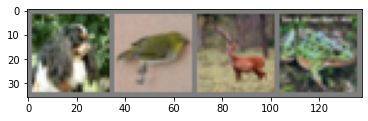

  dog  bird  deer  frog


In [25]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
  img = img / 2 + 0.5   # 標準化を戻す
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()

# 画像を表示
imshow(torchvision.utils.make_grid(images))
# ラベルを表示
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

#### 1.2 CNN, 損失関数, オプティマイザーの定義

In [26]:
import torch.nn as nn
import torch.nn.functional as F
 
 
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
 
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
 
 
net = Net()

In [27]:
import torch.optim as optim
 
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

#### 1.3 ネットワークの訓練

In [28]:
for epoch in range(2):
 
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data     # データの取得
 
        optimizer.zero_grad()    # 勾配の初期化
 
        outputs = net(inputs)    # 順伝播の計算
        loss = criterion(outputs, labels)
        loss.backward()          # 逆伝播の計算
        optimizer.step()         # 重みの計算
 
        running_loss += loss.item()
        if i % 2000 == 1999:    # 2000データずつ出力
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
 
print('Finished Training')

[1,  2000] loss: 2.181
[1,  4000] loss: 1.822
[1,  6000] loss: 1.657
[1,  8000] loss: 1.579
[1, 10000] loss: 1.502
[1, 12000] loss: 1.454
[2,  2000] loss: 1.410
[2,  4000] loss: 1.385
[2,  6000] loss: 1.355
[2,  8000] loss: 1.322
[2, 10000] loss: 1.337
[2, 12000] loss: 1.294
Finished Training


In [29]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

#### 1.4 テストデータを用いたネットワークテスト

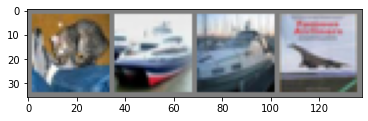

GroundTruth:    cat  ship  ship plane


In [30]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# 画像の表示
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [31]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [32]:
outputs = net(images)
print(outputs[0, :])

tensor([-2.2959, -2.3619,  0.9819,  2.9713,  0.4082,  1.8557,  2.5632, -0.3369,
        -1.8629, -1.6424], grad_fn=<SliceBackward>)


In [33]:
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted:    cat  ship   car  ship


半分正解していた. 全体の正解率を確認する.

In [34]:
correct = 0
total = 0
with torch.no_grad():
  for data in testloader:
    images, labels = data
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 55 %


55%とあまり精度が良くないことが確認できた. ラベル別の正解率を見る.

In [35]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
 
 
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 64 %
Accuracy of   car : 75 %
Accuracy of  bird : 33 %
Accuracy of   cat : 41 %
Accuracy of  deer : 41 %
Accuracy of   dog : 48 %
Accuracy of  frog : 74 %
Accuracy of horse : 56 %
Accuracy of  ship : 65 %
Accuracy of truck : 50 %


車, 飛行機, 船と形が特徴的な乗り物は精度が高い. また, カエルも他の動物とは形が離れていることから精度が高かったと考えた. 次にGPUでの利用の確認を行う.

In [36]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


最後にネットワークの幅を広げた. ここではconv1の第二引数とconv2の第一引数の値を変えて, 最終的なlossの値とtimeモジュールを用いて計測した実行時間を考えた. 結果は以下のようにまとめられた.

| 引数の値 | loss | 実行時間[sec] |
|:---|:---:|---:|
|６ |1.294 |62.292 |
|12 |1.200 |64.846 |
|30 |1.158 |77.396 |

### 感想
PyTorchは今回初めて触れたので全部を完璧にマスターしたとはいえないが, 概ね理解できた. これから使っていきながら理解度を上げていきたい.

### 参考文献
PyTorch 1.5 : PyTorch の学習 : 分類器を訓練する – CIFAR-10
https://torch.classcat.com/2020/04/28/pytorch-1-5-tutorials-learning-cifar10/